In [34]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from collections import defaultdict
import numpy as np
import pandas as pd
import unicodedata

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag, bigrams
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer
import nltk.collocations as collocations
from nltk.util import ngrams


import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, precision_score, recall_score,  confusion_matrix, ConfusionMatrixDisplay,balanced_accuracy_score
from sklearn.metrics import precision_recall_fscore_support, f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate, KFold, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras import datasets, layers, models, callbacks
from kerastuner.tuners import RandomSearch
from imblearn.over_sampling import RandomOverSampler

nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danayt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/danayt/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package tagsets to /Users/danayt/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/danayt/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /Users/danayt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# !pip install keras-tuner

In [3]:
data = pd.read_csv("../raw_data/judge-1377884607_tweet_product_company.csv", encoding='unicode_escape')

In [4]:
# dopping null column from tweet_text column since it's only one and has no information for our analysis
data.tweet_text.isna().sum()
data.dropna(subset=['tweet_text'], inplace=True)

In [5]:
# looking at our .describe, there seems to be some duplicates in our data and we'll go ahead and keep unique inputs only
data.drop_duplicates(subset=['tweet_text'], inplace=True)

In [6]:
# Creating a cleaned emotion_in tweet_is_directed_at column
data.rename(columns={'emotion_in_tweet_is_directed_at': 'brand'}, inplace=True)
data.rename(columns={'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'}, inplace=True)

In [7]:
keywords = ["Apple", "Google", "iPad", "iPhone", "Android", "goog"]

for keyword in keywords:
    data[keyword] = data['tweet_text'].str.extract(f'({keyword})', flags=re.IGNORECASE)

data['product'] = data[['Apple', 'iPhone', 'iPad', 'Google', 'Android']].apply(lambda x: 'Apple' if x[['Apple', 'iPhone', 'iPad']].any() 
                                                                                else 'Google' if x[['Google', 'Android']].any() 
                                                                                else None, axis=1)

In [8]:
data

,tweet_text,brand,sentiment,Apple,Google,iPad,iPhone,Android,goog,product
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion,NaN,NaN,Ipad,NaN,NaN,NaN,Apple
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product,NaN,google,NaN,NaN,NaN,goog,Google
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product,NaN,Google,NaN,NaN,NaN,Goog,Google
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product,NaN,NaN,NaN,iPhone,NaN,NaN,Apple
9092,Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...,NaN,No emotion toward brand or product,NaN,Google,NaN,NaN,NaN,Goog,Google


In [9]:
data['product'].value_counts()

product
Apple     5517
Google    2764
Name: count, dtype: int64

In [10]:
# Since we've classified our product column, we'll drop nulls as we're interested with apple and google products
data['product'].isna().sum()

784

In [11]:
#Dropped to focus on tweets where google and apple where mentioned
data.dropna(subset=['product'], inplace=True)

In [12]:
data['sentiment'].replace("I can't tell" , "Neutral emotion", inplace=True)
data['sentiment'].replace("No emotion toward brand or product" , "Neutral emotion", inplace=True)
data['sentiment'].replace("No emotion toward brand or product" , "Neutral emotion", inplace=True)

In [13]:
target_to_replace = {'Positive emotion':2, 'Neutral emotion':1,
                   'Negative emotion':0}

data['sentiment']  = data['sentiment'].replace(target_to_replace)

In [14]:
data['sentiment'].value_counts()

sentiment
1    4783
2    2930
0     568
Name: count, dtype: int64

In [15]:
data['product'].value_counts()

product
Apple     5517
Google    2764
Name: count, dtype: int64

In [16]:
data['product'] = data['product'].astype(str)

In [17]:
sw = stopwords.words('english')
sw.extend(["apple", "google", "ipad", "iphone", "android", "sxsw", "link", "mention", "sxwsi", "hmmm", "sxswu", "goog", "iusxsw",
           "etc", "via", "today", "hmmmm"])

In [18]:
# Custom tokenizer
def doc_preparer(doc, stop_words=sw):

    #lemmatized, parsed for stopwords, made lowercase,and stripped of punctuation and numbers.
    doc = unicodedata.normalize('NFKD', doc).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # Remove URLs
    doc = re.sub(r'http\S+|www\S+|https\S+', '', doc, flags=re.MULTILINE)
    # Remove mentions and hashtags
    doc = re.sub(r'\@\w+|\#','', doc)
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    doc = [word for word in doc if len(word) > 1]  # Remove tokens with length <= 1
    # print(doc)
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)
 # Translate nltk POS to wordnet tags
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [19]:
# Extracting important features from our data 
corpse = data.tweet_text
target = data.sentiment
product = data.product

In [20]:
token_text = [doc_preparer(doc,sw) for doc in corpse]

In [21]:
# Convert the 'product' column to strings
data['product'] = data['product'].astype(str)

# Concatenate the "corpse" and "product" columns
data['text_with_product'] = [text + ' ' + product for text, product in zip(token_text, data['product'])]

# Assign the concatenated text to X
X = data['text_with_product']

# Assign the target labels to y
y = data['sentiment']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.25)

In [23]:
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train,
                                          test_size=0.25, random_state=42)

In [24]:
#ui
#lt
#rt

# Baseline Model, MultinomialNB

In [25]:
tfidf = TfidfVectorizer(ngram_range=(1, 2))

X_t_vec = tfidf.fit_transform(X_t)

X_val_vec = tfidf.transform(X_val)

mnb = MultinomialNB()

mnb.fit(X_t_vec, y_t)
y_hat = mnb.predict(X_val_vec)

precision_score(y_val, y_hat, average='weighted')

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6314154919339979

In [26]:
y_hat = mnb.predict(X_val_vec)
accuracy_score(y_val, y_hat)

0.657437218287186

In [27]:
y_t_mnb = mnb.predict(X_t_vec)
y_t_pred_mnb= mnb.predict(X_val_vec)

print("Accuracy:")
train_accuracy = accuracy_score(y_t, y_t_mnb)
print("Train Accuracy:", train_accuracy)

test_accuracy = accuracy_score(y_val, y_t_pred_mnb)
print("Test Accuracy:", test_accuracy)

print("\nBalanced Accuracy:")
train_accuracy = balanced_accuracy_score(y_t, y_t_mnb)
print("Train Accuracy:", train_accuracy)

test_accuracy = balanced_accuracy_score(y_val, y_t_pred_mnb)
print("Test Accuracy:", test_accuracy)

Accuracy:
Train Accuracy: 0.8200558299334335
Test Accuracy: 0.657437218287186

Balanced Accuracy:
Train Accuracy: 0.5724864220076644
Test Accuracy: 0.4076328192297774


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       103
           1       0.65      0.95      0.77       924
           2       0.73      0.27      0.40       526

    accuracy                           0.66      1553
   macro avg       0.46      0.41      0.39      1553
weighted avg       0.63      0.66      0.59      1553



/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

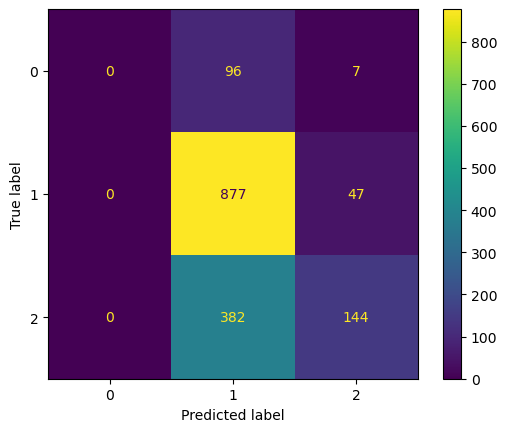

In [32]:
print(classification_report(y_val, y_t_pred_mnb)) 
cm = confusion_matrix(y_val, y_t_pred_mnb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Balanced MultinomialNB

In [44]:
# Create an instance of RandomOverSampler
oversampler = RandomOverSampler()

# Resample the data
X_resampled, y_resampled = oversampler.fit_resample(X_t_vec, y_t)


# Create and fit the MultinomialNB model
mnb1 = MultinomialNB()
mnb1.fit(X_resampled, y_resampled)

MultinomialNB()

In [42]:
# y_t_pred_mnb1 = mnb1.predict(X_t_vec)

array([1, 1, 2, ..., 0, 2, 2])

In [45]:
y_t_mnb1 = mnb1.predict(X_t_vec)
y_t_pred_mnb1 = mnb1.predict(X_val_vec)

print("Accuracy:")
train_accuracy = accuracy_score(y_t, y_t_mnb1)
print("Train Accuracy:", train_accuracy)

test_accuracy = accuracy_score(y_val, y_t_pred_mnb1)
print("Test Accuracy:", test_accuracy)

print("\nBalanced Accuracy:")
train_accuracy = balanced_accuracy_score(y_t, y_t_mnb1)
print("Train Accuracy:", train_accuracy)

test_accuracy = balanced_accuracy_score(y_val, y_t_pred_mnb1)
print("Test Accuracy:", test_accuracy)

Accuracy:
Train Accuracy: 0.9057333047025983
Test Accuracy: 0.6097875080489376

Balanced Accuracy:
Train Accuracy: 0.926226053491909
Test Accuracy: 0.5828907619302244


              precision    recall  f1-score   support

           0       0.25      0.52      0.34       103
           1       0.75      0.63      0.68       924
           2       0.55      0.60      0.57       526

    accuracy                           0.61      1553
   macro avg       0.52      0.58      0.53      1553
weighted avg       0.65      0.61      0.62      1553



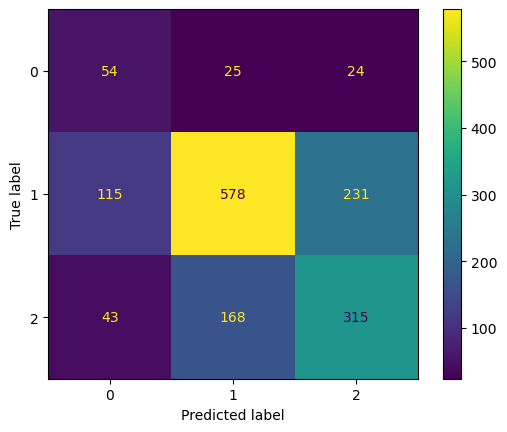

In [46]:
print(classification_report(y_val, y_t_pred_mnb1)) 
cm = confusion_matrix(y_val, y_t_pred_mnb1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# LogisticRegression

In [28]:
lr =  LogisticRegression(random_state =42, multi_class='multinomial', solver='saga', class_weight='balanced', n_jobs=-1)

lr.fit(X_t_vec, y_t)
y_hat = lr.predict(X_val_vec)

precision_score(y_val, y_hat, average='weighted')

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.6697035972529065

In [29]:
y_t_lr = lr.predict(X_t_vec)
y_t_pred_lr= lr.predict(X_val_vec)

print("Accuracy:")
train_accuracy = accuracy_score(y_t, y_t_lr)
print("Train Accuracy:", train_accuracy)

test_accuracy = accuracy_score(y_val, y_t_pred_lr)
print("Test Accuracy:", test_accuracy)

print("\nBalanced Accuracy:")
train_accuracy = balanced_accuracy_score(y_t, y_t_lr)
print("Train Accuracy:", train_accuracy)

test_accuracy = balanced_accuracy_score(y_val, y_t_pred_lr)
print("Test Accuracy:", test_accuracy)

Accuracy:
Train Accuracy: 0.6691002791496672
Test Accuracy: 0.4713457823567289

Balanced Accuracy:
Train Accuracy: 0.7780168563909768
Test Accuracy: 0.5650605797990346


              precision    recall  f1-score   support

           0       0.13      0.76      0.23       103
           1       0.79      0.40      0.53       924
           2       0.57      0.53      0.55       526

    accuracy                           0.47      1553
   macro avg       0.50      0.57      0.44      1553
weighted avg       0.67      0.47      0.52      1553



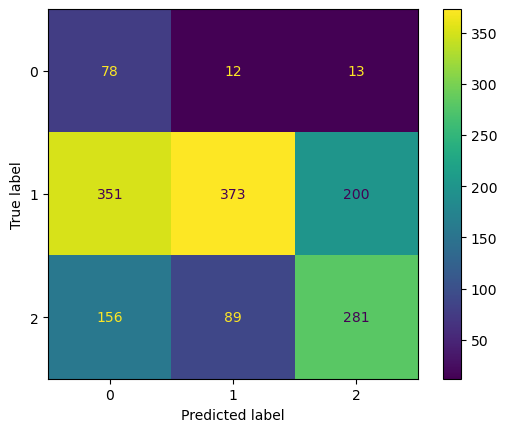

In [30]:
print(classification_report(y_val, y_t_pred_lr)) 
cm = confusion_matrix(y_val, y_t_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [47]:
X_t_vec_dense = X_t_vec.toarray()
X_val_vec_dense = X_val_vec.toarray()

In [ ]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_t), y=y_t)

# Define the RNN model
embedding_dim = 500  # Adjust the dimension based on your data
lstm_units = 64  # Adjust the number of LSTM units based on your data
num_classes = len(np.unique(y_t))  # Calculate the number of classes
batch_size = 64  # Adjust the batch size based on your data
epochs = 20  # Adjust the number of epochs based on your data

model = Sequential()
model.add(Embedding(input_dim=X_t_vec_dense.shape[1], output_dim=embedding_dim, input_length=X_t_vec_dense.shape[1]))
model.add(LSTM(units=lstm_units))
model.add(Dense(units=num_classes, activation='softmax'))

# Compile the model with appropriate loss function and class weights
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

unique_classes = np.unique(y_t)
class_weights_dict = {}
for class_index in unique_classes:
    class_weights_dict[class_index] = class_weights[class_index]

model.fit(X_t_vec_dense, y_t, batch_size=batch_size, epochs=epochs, validation_data=(X_val_vec_dense, y_val), class_weight=class_weights_dict)

Epoch 1/20


2023-10-24 22:32:32.676218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


36/73 [=============>................] - ETA: 29:02 - loss: 1.0926 - accuracy: 0.4119

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Insufficient Memory (00000008:kIOGPUCommandBufferCallbackErrorOutOfMemory)
	<AGXG14GFamilyCommandBuffer: 0x31cdad030>
    label = <none> 
    device = <AGXG14GDevice: 0x126b93a00>
        name = Apple M2 
    commandQueue = <AGXG14GFamilyCommandQueue: 0x116981600>
        label = <none> 
        device = <AGXG14GDevice: 0x126b93a00>
            name = Apple M2 
    retainedReferences = 1


73/73 [==============================] - 2049s 28s/step - loss: 1.0988 - accuracy: 0.3955 - val_loss: 1.0972 - val_accuracy: 0.5879
Epoch 2/20
 4/73 [>.............................] - ETA: 8:45 - loss: 0.9733 - accuracy: 0.6289

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Insufficient Memory (00000008:kIOGPUCommandBufferCallbackErrorOutOfMemory)
	<AGXG14GFamilyCommandBuffer: 0x323dff4c0>
    label = <none> 
    device = <AGXG14GDevice: 0x126b93a00>
        name = Apple M2 
    commandQueue = <AGXG14GFamilyCommandQueue: 0x116981600>
        label = <none> 
        device = <AGXG14GDevice: 0x126b93a00>
            name = Apple M2 
    retainedReferences = 1


10/73 [===>..........................] - ETA: 7:47 - loss: 1.0156 - accuracy: 0.6016

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Insufficient Memory (00000008:kIOGPUCommandBufferCallbackErrorOutOfMemory)
	<AGXG14GFamilyCommandBuffer: 0x323fb7200>
    label = <none> 
    device = <AGXG14GDevice: 0x126b93a00>
        name = Apple M2 
    commandQueue = <AGXG14GFamilyCommandQueue: 0x116981600>
        label = <none> 
        device = <AGXG14GDevice: 0x126b93a00>
            name = Apple M2 
    retainedReferences = 1


19/73 [======>.......................] - ETA: 6:38 - loss: 1.1160 - accuracy: 0.5625

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Insufficient Memory (00000008:kIOGPUCommandBufferCallbackErrorOutOfMemory)
	<AGXG14GFamilyCommandBuffer: 0x3224688d0>
    label = <none> 
    device = <AGXG14GDevice: 0x126b93a00>
        name = Apple M2 
    commandQueue = <AGXG14GFamilyCommandQueue: 0x116981600>
        label = <none> 
        device = <AGXG14GDevice: 0x126b93a00>
            name = Apple M2 
    retainedReferences = 1


22/73 [========>.....................] - ETA: 6:17 - loss: 1.1084 - accuracy: 0.5632

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Insufficient Memory (00000008:kIOGPUCommandBufferCallbackErrorOutOfMemory)
	<AGXG14GFamilyCommandBuffer: 0x28d44db00>
    label = <none> 
    device = <AGXG14GDevice: 0x126b93a00>
        name = Apple M2 
    commandQueue = <AGXG14GFamilyCommandQueue: 0x116981600>
        label = <none> 
        device = <AGXG14GDevice: 0x126b93a00>
            name = Apple M2 
    retainedReferences = 1


35/73 [=============>................] - ETA: 4:36 - loss: 1.1145 - accuracy: 0.5388

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Insufficient Memory (00000008:kIOGPUCommandBufferCallbackErrorOutOfMemory)
	<AGXG14GFamilyCommandBuffer: 0x325195230>
    label = <none> 
    device = <AGXG14GDevice: 0x126b93a00>
        name = Apple M2 
    commandQueue = <AGXG14GFamilyCommandQueue: 0x116981600>
        label = <none> 
        device = <AGXG14GDevice: 0x126b93a00>
            name = Apple M2 
    retainedReferences = 1


42/73 [================>.............] - ETA: 3:44 - loss: 1.1082 - accuracy: 0.5000

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Insufficient Memory (00000008:kIOGPUCommandBufferCallbackErrorOutOfMemory)
	<AGXG14GFamilyCommandBuffer: 0x322469ff0>
    label = <none> 
    device = <AGXG14GDevice: 0x126b93a00>
        name = Apple M2 
    commandQueue = <AGXG14GFamilyCommandQueue: 0x116981600>
        label = <none> 
        device = <AGXG14GDevice: 0x126b93a00>
            name = Apple M2 
    retainedReferences = 1


60/73 [=======================>......] - ETA: 1:35 - loss: 1.1024 - accuracy: 0.4068

In [ ]:
# # Calculate class weights
# class_weights = compute_class_weight('balanced', classes=np.unique(y_t), y=y_t)

# # Define the RNN model
# embedding_dim = 100  
# lstm_units = 64 
# num_classes = len(np.unique(y_t))  
# batch_size = 32  

# model = Sequential()
# model.add(Embedding(input_dim=X_t_vec_dense.shape[1], output_dim=embedding_dim, input_length=X_t_vec_dense.shape[1]))
# model.add(LSTM(units=lstm_units))
# model.add(Dense(units=num_classes, activation='softmax'))

# # Compile the model with appropriate loss function and class weights
# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# unique_classes = np.unique(y_t)
# class_weights_dict = {}
# for class_index in unique_classes:
#     class_weights_dict[class_index] = class_weights[class_index]

# model.fit(X_t_vec_dense, y_t, batch_size=batch_size, epochs=epochs, validation_data=(X_val_vec_dense, y_val), class_weight=class_weights_dict)


In [ ]:
# Define the model-building function
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=X_t_vec_dense.shape[1], output_dim=hp.Int('embedding_dim', min_value=50, max_value=300, step=50), input_length=X_t_vec_dense.shape[1]))
    model.add(LSTM(units=hp.Int('lstm_units', min_value=64, max_value=256, step=64)))
    model.add(Dense(units=num_classes, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Define the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Adjust the number of trials based on your computational resources
    executions_per_trial=1,
    directory='my_dir',
    project_name='my_project'
)

# Perform the hyperparameter search
tuner.search(X_t_vec_dense, y_t, validation_data=(X_val_vec_dense, y_val), epochs=10, batch_size=32)

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)


In [ ]:
#How to pull a specific predictor out

In [ ]:
# Our baseline model is not bad, performance at 0.689 with TFIDF

In [ ]:
# Grid search and Modeling

In [ ]:
# # Define the MNB pipeline
# nbpipe = Pipeline([
#     ('vect', TfidfVectorizer(ngram_range=(1, 2))),
#     ('clf', MultinomialNB())
# ])

# # Fit the pipeline to the training data
# nbpipe.fit(X_t, y_t)

In [ ]:

# # Specify hyperparameters and their distributions
# parameters = {
#     'vect__ngram_range': [(1,1), (1,2), (2,2)],
#     'vect__max_df': [0.5, 0.75, 1.0],
#     'vect__min_df': [0.01, 0.05, 0.1],
#     'vect__max_features': [500, 1000, 20],
#     'vect__stop_words': [None, 'english'],
#     'vect__analyzer': ['word', 'char', 'char_wb'],
#     'clf__alpha': [0.0, 0.5, 1.0, 2.0],
#     'clf__fit_prior': [True, False]
# }

In [ ]:
# Instantiate GridSearchCV object using the lrpipe pipeline
# grid_search = GridSearchCV(nbpipe, parameters, n_jobs=-1, cv=5)

# # Fit on data
# grid_search.fit(X_t, y_t)

In [ ]:
# # Get the best parameters
# best_params = grid_search.best_params_
# best_params

In [ ]:
# y_t_gr = grid_search.predict(X_t)
# y_t_pred_gr= grid_search.predict(X_val)

# print("Accuracy:")
# train_accuracy = accuracy_score(y_t, y_t_gr)
# print("Train Accuracy:", train_accuracy)

# test_accuracy = accuracy_score(y_val, y_t_pred_gr)
# print("Test Accuracy:", test_accuracy)

# print("\nBalanced Accuracy:")
# train_accuracy = balanced_accuracy_score(y_t, y_t_gr)
# print("Train Accuracy:", train_accuracy)

# test_accuracy = balanced_accuracy_score(y_val, y_t_pred_gr)
# print("Test Accuracy:", test_accuracy)

In [ ]:
#RNN's